In this project we are using kaggle german traffic signal dataset which is already labeled. Uisng Keras to classify the signals based on 43 classes. 
At the end we are using GUI programming with Tkinter


##### The architecture of our model is:

    2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)
    MaxPool2D layer ( pool_size=(2,2))
    Dropout layer (rate=0.25)
    2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)
    MaxPool2D layer ( pool_size=(2,2))
    Dropout layer (rate=0.25)
    Flatten layer to squeeze the layers into 1 dimension
    Dense Fully connected layer (256 nodes, activation=”relu”)
    Dropout layer (rate=0.5)
    Dense layer (43 nodes, activation=”softmax”)

Note: We compile the model with Adam optimizer which performs well and loss is “categorical_crossentropy” because we have multiple classes to categorise.

After building the model architecture, we then train the model using model.fit(). We tried with batch size 32 and 64. Our model performed better with 64 batch size. And after 15 epochs the accuracy was stable.

Next step is to save the model and use it again for image classificaiton based on the model that we prepared above.
At the end we are using Tkinter to build a graphical user interface for traffic signs classifier.

## Some of the notes for new learners:
#### 1. What is batch?

    It's the hyperparameter that defines the number of samples to work through before updating the internal model parameter. We can think of it as for loop iterating over one or more samples and make predictions. at the end of batch, the predictions are compared to expected output varibales and erroris calculated.
    
    The training dataset can be divided into one or more batches. When all trianing samples are used to create one batch, it is called gradient batch. when batch is size of one sample then its called stochastic gradient descent. Popular batch sizes are 32, 64, 128.
    
    The batch size is a number of samples processed before the model is updated.
   
   
#### 2. What is Epoch?

    The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.
    
    The number of epochs is the number of complete passes through the training dataset.

### In nutshell:

        Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.
        The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
        The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

    


In [98]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
import os, sys
#import tensorflow.compat.v1 as tf
from skimage import transform
from skimage import data
from skimage.color import rgb2gray

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model


In [88]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk

We tried two different trafic dataset. one is subpart of other. 

In [14]:
def load_data(data_directory):
    
    #getting the directories in each folder and then we will did the files in the directory
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    
    # looking for the pmm files only and then putting the names in directory
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) if f.endswith(".ppm")]
        
        # reading the images using matplotlib
        for f in file_names:
            images.append(plt.imread(f))
            labels.append(int(d))
    return images, labels

In [15]:
train_data_directory = "data/BelgiumTSC_Training/Training"
images, labels = load_data(train_data_directory)

In [16]:
type(images)

list

In [17]:
images_array = np.array(images)
labels_array = np.array(labels)

In [18]:
print(images_array.ndim)

1


Text(0.5, 0, 'Labels (Bins)')

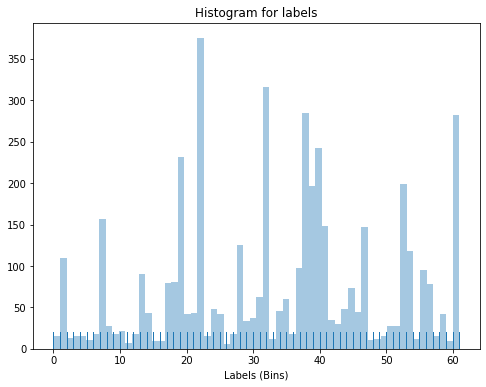

In [19]:
plt.figure(figsize = (8, 6))

sns.distplot(labels, bins=62 , kde=False, rug=True);
plt.title('Histogram for labels')
plt.xlabel('Labels (Bins)')

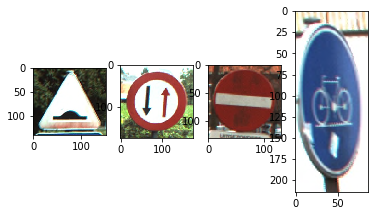

In [20]:
# printing the random signs from dataset
traffic_signs= [100,1000,1230,2498]
for i in range(len(traffic_signs)):
    plt.subplot(1,4,i+1)
    plt.imshow(images[traffic_signs[i]])
    #plt.subplots_adjust(wspace=0.5)

plt.show()

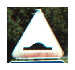

shape: (139, 152, 3), min: 0, max: 255


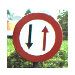

shape: (175, 175, 3), min: 2, max: 255


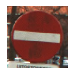

shape: (131, 130, 3), min: 9, max: 255


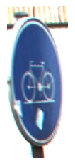

shape: (214, 86, 3), min: 14, max: 255


In [21]:
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images[traffic_signs[i]].shape, 
                                                  images[traffic_signs[i]].min(), 
                                                  images[traffic_signs[i]].max()))

In [22]:
unique_labels = set(labels)
print(unique_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61}


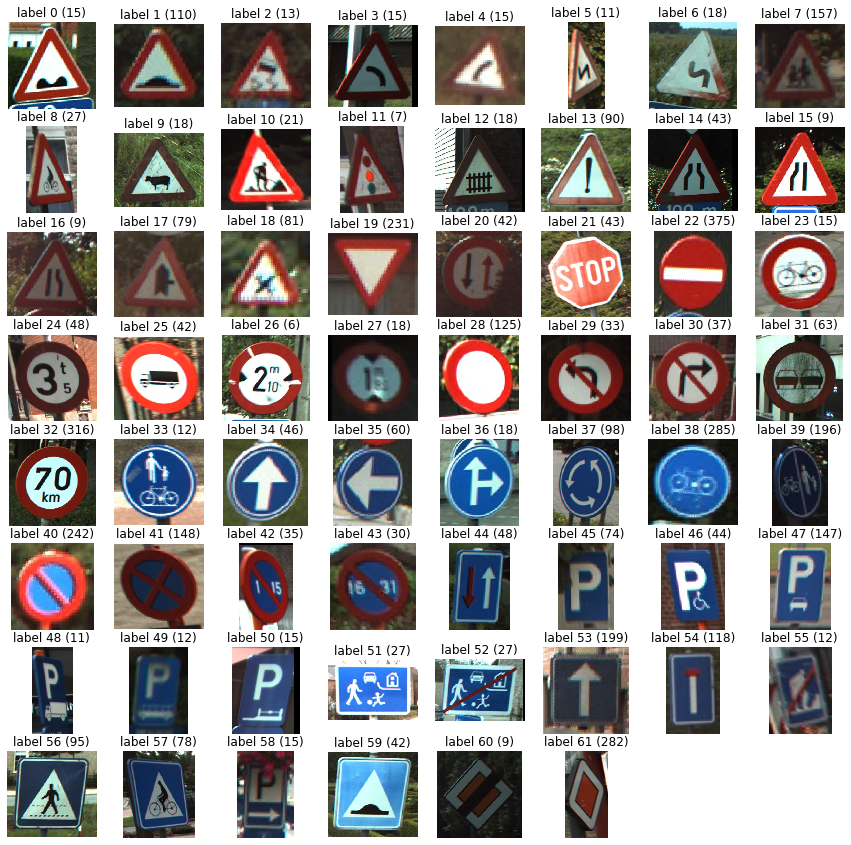

In [23]:
plt.figure(figsize = (15, 15))
i=0
for label in unique_labels:
    # we are picking the first image of every label
    plt.subplot(8, 8, i+1)
    plt.imshow(images[labels.index(label)])
    plt.title("label {0} ({1})".format(label, labels.count(label)))
    plt.axis('off')
    i += 1

## extracting features
#### why do we need this?
    1 sizes of the images are unequal we saw that above
    2. converting it to gery scale, the color of the images are of less importance when we are trying to classigy the images
    
    
#### How are we going to do this:
    1. rescaling the images using skimage.transform.resize() converting it to 28 * 28 pixels
    2. gray scale using rgb2gray()

In [25]:
images28 = [transform.resize(image,(28, 28)) for image in images]
print(type(images28))
images28 = np.array(images28)

<class 'list'>


In [26]:
(images28[0].shape)

(28, 28, 3)

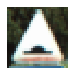

shape: (28, 28, 3), min: 0.047058823529411764, max: 0.9921568627450981


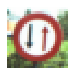

shape: (28, 28, 3), min: 0.16078431372549018, max: 0.996078431372549


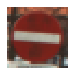

shape: (28, 28, 3), min: 0.09803921568627452, max: 0.9021708683473382


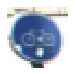

shape: (28, 28, 3), min: 0.1424369747899159, max: 1.0


In [27]:
# printing resized images
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images28[traffic_signs[i]])
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images28[traffic_signs[i]].shape, 
                                                  images28[traffic_signs[i]].min(), 
                                                  images28[traffic_signs[i]].max()))

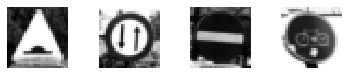

In [28]:
#2.  converting images to gray scale
images28 = rgb2gray(images28)
for i in range(len(traffic_signs)):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(images28[traffic_signs[i]], cmap="gray")
    plt.subplots_adjust(wspace=0.5)

# deep learnign with tensor flow

### Modeling the Neural network

    1. defining paceholders (x -> input, y -> labels) ----> 
    2. flattening the input [None, 784] from [None, 28, 28] ----> 
    3. construct a fully logits of size [none, 62], Logits is an function operates on the unscaled output of previous layers and uses the relative scale to understand the units in linear --->
    4. defining the loss function. here we compute sparse softmax cross entropy between logits and labels. Here we wrap this function using reduced_mean() which computes the mean of elements across dimensions of the tensor
    defining the optimizer


Notes:

<font color=red>sparse_softmax_cross_entropy_with_logits()</font> ->it measures the probability error in discrete classification tasksin which the classes are mutually exclusive.each entry is exactly one class, here each sign can only have single label. 

<font color=red>Popular optimizer algo:</font> Stochastic Gradient Descent (SGD), ADAM and RMSprop.

In [29]:
from tf_slim.layers import layers as _layers

In [36]:
# defining paceholders for the inputs and the labels
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.float32, shape = [None])

# flattening the input data
images_flat = tf.layers.flatten(x)

# fully connected layer
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# defining the loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits))

# defining an optimizer
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# converting logits to label indexes
correct_pred = tf.argmax(logits, 1)

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


AttributeError: module 'tensorflow_core.compat.v1' has no attribute 'contrib'

In [58]:
data = []
labels2 = []
classes= 43
path =  "data\gtsrb-german-traffic-sign\Train"

for d in range(classes):
    print(d)
    label_directory = os.path.join(path, str(d))
    file_names = [os.path.join(label_directory, f) 
                  for f in os.listdir(label_directory) if f.endswith(".png")]
    for f in file_names:
        image = Image.open(f)
        image = image.resize((30,30))
        image = np.array(image)
        data.append(image)
        labels2.append(d)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [59]:
data = np.array(data)
labels2 = np.array(labels2)

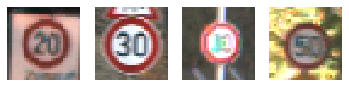

In [60]:
traffic_signs= [100,1000,1230,2498]
for i in range(len(traffic_signs)):
    plt.subplot(1,4,i+1)
    plt.imshow(data[traffic_signs[i]])
    #plt.subplots_adjust(wspace=0.5)
    plt.axis('off')


plt.show()

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data, labels2, test_size=0.2, random_state=42)

# we use to_categorical method to convert the labels present in y_train and t_test into one-hot encoding.
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

### CNN model steps

    2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)
    MaxPool2D layer ( pool_size=(2,2))
    Dropout layer (rate=0.25)
    2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)
    MaxPool2D layer ( pool_size=(2,2))
    Dropout layer (rate=0.25)
    Flatten layer to squeeze the layers into 1 dimension
    Dense Fully connected layer (256 nodes, activation=”relu”)
    Dropout layer (rate=0.5)
    Dense layer (43 nodes, activation=”softmax”)

In [62]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation = 'relu', input_shape= X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation = 'relu'))
model.add(MaxPool2D())
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [63]:
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))
model.save("model_traffic_signal.h5")

Train on 31367 samples, validate on 7842 samples
Epoch 1/15
31367/31367 [==============================] - 106s 3ms/step - loss: 2.0966 - accuracy: 0.4579 - val_loss: 0.6254 - val_accuracy: 0.8328
Epoch 2/15
31367/31367 [==============================] - 99s 3ms/step - loss: 0.7981 - accuracy: 0.7583 - val_loss: 0.3440 - val_accuracy: 0.9055
Epoch 3/15
31367/31367 [==============================] - 93s 3ms/step - loss: 0.5676 - accuracy: 0.8265 - val_loss: 0.1910 - val_accuracy: 0.9438
Epoch 4/15
31367/31367 [==============================] - 89s 3ms/step - loss: 0.4622 - accuracy: 0.8590 - val_loss: 0.1875 - val_accuracy: 0.9452
Epoch 5/15
31367/31367 [==============================] - 88s 3ms/step - loss: 0.4028 - accuracy: 0.8819 - val_loss: 0.1263 - val_accuracy: 0.9629
Epoch 6/15
31367/31367 [==============================] - 89s 3ms/step - loss: 0.3323 - accuracy: 0.9024 - val_loss: 0.2013 - val_accuracy: 0.9403
Epoch 7/15
31367/31367 [==============================] - 88s 3ms/st

NotImplementedError: numpy() is only available when eager execution is enabled.

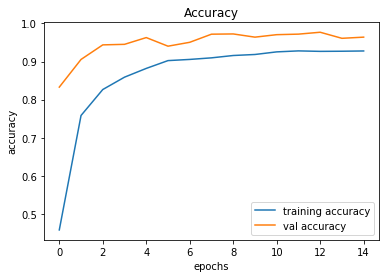

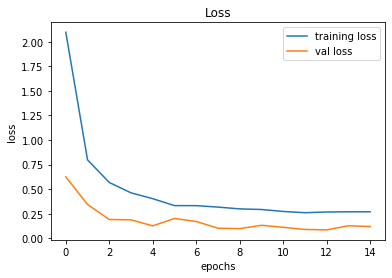

In [65]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [85]:
y_test = pd.read_csv('data\gtsrb-german-traffic-sign\Test.csv') 

labels = np.array(y_test.ClassId.tolist())
imgs = np.array(y_test.Path.tolist())

data = []

for img in imgs:
    test_dir = os.path.join("data\gtsrb-german-traffic-sign", img)
    image = Image.open(test_dir)
    image = image.resize((30, 30))
    data.append(np.array(image))

X_test=np.array(data)
pred = model.predict_classes(X_test)
#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

0.923040380047506


In [102]:
#model.save("traffic_classifier.h5")

In [97]:
model = load_model('traffic_classifier.h5')

C:\Users\sidha\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Here classify_image() function is used to 

In [103]:
#dictionary to label all traffic signs class.
classes = { 1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }

#initialize GUI
# here we are building GUI for uploading the image# top is the instance od Tkinker class
top = tk.Tk()
top.geometry('800x600')
top.title('Traffic sign classification')
top.configure(background='#CDCDCD')

label= Label(top ,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)


In [106]:
greeting = tk.Label(text="Hello, Tkinter")
greeting.pack()

In [107]:
def classify_image(path):
    img = Image.open(path)
    img = img.resize((30,30))
    img = np.array(img)
    pred = model.predict_classes([img])[0]
    sign = classes[pred + 1]
    print(sign)
    label.configure(foreground='#011638', text=sign)

In [ ]:
def classify_button(path):
    